Analyzing the baroclinic tide at VENUS nodes

In [1]:
import datetime
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as nc

from salishsea_tools import (viz_tools,tidetools, nc_tools, ellipse)
from salishsea_tools.nowcast import (research_VENUS, analyze)

import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style('darkgrid')

In [3]:
path='/data/dlatorne/MEOPAR/SalishSea/nowcast/'
SITES = research_VENUS.SITES['VENUS']
NodalCorr = tidetools.CorrTides

In [4]:
to=datetime.datetime(2014,11,26)
tf=datetime.datetime(2015,4,26)

us = {}; vs = {}; depths= {}; times={}

for site in SITES:
    fname = '{}_currents_{}_{}.nc'.format(site, to.strftime('%Y%m%d'), tf.strftime('%Y%m%d'))
    
    f = nc.Dataset(fname)
    
    us[site] = f.variables['vozocrtx'][:]
    vs[site] = f.variables['vomecrty'][:]
    depths[site] = f.variables['deptht'][:]
    times[site] = f.variables['time_counter'][:]

Question - should I exclude the surface layer in the depth averaged currents or not?

Let's try not and see how different the ellipse paramters are.  

In [5]:
def nodal_corrections(tide, tidecorr):
    """apply nodal corrections to tidal constituent amplude and phase
    
    tide is a nested dictionary with phase and ampliude for each constituent
    tidecorr is also a nested dictionary with nodal factors and phase shift for each constituent"""
    for const in tide:
        tide[const]['phase'] = (tide[const]['phase'] + tidecorr[const]['uvt'])
        tide[const]['amp'] = tide[const]['amp'] / tidecorr[const]['ft']
        
        tide[const]['amp'], tide[const]['phase'] = tidetools.convention_pha_amp(
                tide[const]['amp'], tide[const]['phase'])
    return tide

In [6]:
nconst=8
barotropic_ellipse ={} # barotropic ellipse parameters (depth averaged)
u_rot ={}; v_rot={} #rotated full currents
u_rot_depav={}; v_rot_depav={} # rotated, depth averaged currents
u_tide_bt={}; v_tide_bt={} # barotropic tidal constituents (depth averaged)
for site in SITES:
    u_rot[site],v_rot[site] = ellipse.prepare_vel(us[site], vs[site])
    #ellipses and tide fits for u/ rotates
    u_rot_depav[site],v_rot_depav[site] = ellipse.prepare_vel(us[site], vs[site], depav=True, depth=depths[site])
    u_tide_bt[site] = tidetools.fittit(u_rot_depav[site],times[site], nconst )
    v_tide_bt[site] = tidetools.fittit(v_rot_depav[site],times[site], nconst )
    #nodal corrections
    #u_tide_baro[site] = nodal_corrections(u_tide_bt[site], NodalCorr)
    #v_tide_baro[site] = nodal_corrections(v_tide_baro[site], NodalCorr)
    
    barotropic_ellipse[site] = ellipse.get_params(u_rot_depav[site], v_rot_depav[site], times[site], nconst)

Construct barotopic tidal curents M2 prediction

In [7]:
u_bt_pred = {} #barotopic tidal prediction - u
v_bt_pred = {} #barotropic tidal predition - v

for site in SITES:
    u_bt_pred[site] = np.zeros(len(times[site]))
    v_bt_pred[site] = np.zeros(len(times[site]))
    for const in ['M2']:
        ampU = u_tide_bt[site][const]['amp'] #* NodalCorr[const]['ft']
        phaU = u_tide_bt[site][const]['phase']# - NodalCorr[const]['uvt']
        u_bt_pred[site] = u_bt_pred[site] + ampU*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaU)*np.pi/180)
        
        ampV = v_tide_bt[site][const]['amp'] #* NodalCorr[const]['ft']
        phaV = v_tide_bt[site][const]['phase'] #- NodalCorr[const]['uvt']
        v_bt_pred[site] = v_bt_pred[site] + ampV*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaV)*np.pi/180)
        

Check that phase, etc is reasonable by plotting

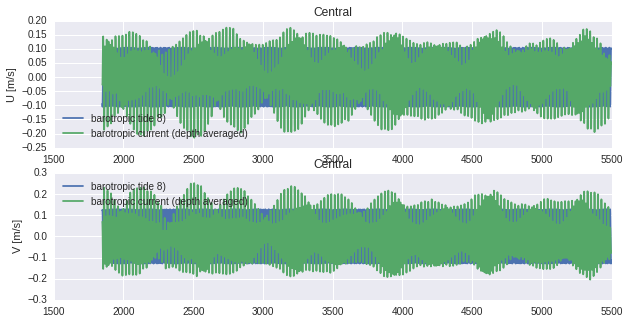

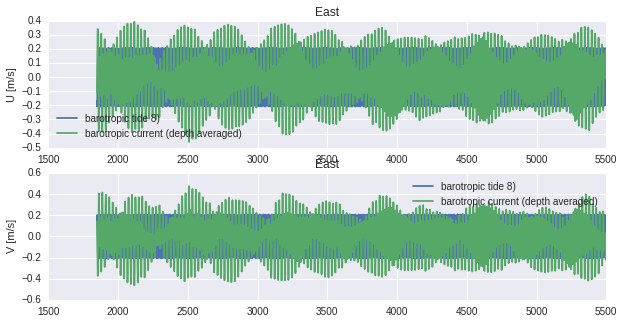

In [8]:
for site in ['Central', 'East']:
    fig,axs=plt.subplots(2,1, figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bt_pred[site][0,:],label='barotropic tide 8)')
    ax.plot(times[site], u_rot_depav[site][:,0,0] - np.mean(u_rot_depav[site]),label = 'barotropic current (depth averaged)')
    ax.legend(loc=0)
    ax.set_ylabel('U [m/s]')
    ax.set_title(site)
    ax=axs[1]
    ax.plot(times[site], v_bt_pred[site][0,:],label='barotropic tide 8)')
    ax.plot(times[site], v_rot_depav[site][:,0,0] - np.mean(v_rot_depav[site]),label = 'barotropic current (depth averaged)')
    ax.legend(loc=0)
    ax.set_ylabel('V [m/s]')
    ax.set_title(site)

#Baroclinic Tide

Looks like tidal predictions reproduce the depth averaged currents reasonably well.

In [15]:
def baroclinic_tide(u, time, depth, nconsts):
    """Perform a harmonic analysis on the baroclinic tide
    
    u is the full depth profile of a current
    If u is from NEMO output, it should be unstaggered before this funcion is applied. 
    u should have at least a time and depth dimension but could also have y, x shape
    the depth dimensions must be in axis 1.
    
    time is the times associated with the current.
    
    depth is an array of depths associated with u
    
    nconsts is the number of constituents to analyze
    
    returns tide_bc - a nested dictionary with amp and phase for each constituent 
    eg. tide_bc['M2']['phase']"""
    
    #Calculate depth-averaged current
    u_depav = analyze.depth_average(u, depth, depth_axis=1)
    
    #Caclulate baroclinic current by removing depth averaged bit
    u_bc = u - u_depav
    
    #tidal analysss of baroclinic current
    tide_bc = tidetools.fittit(u_bc, time, nconst)
    
    return tide_bc, u_bc

In [16]:
u_tide_bc = {} #baroclinc tidal constituents - u
v_tide_bc = {} # baroclinic tidal constitnets - v
u_bc = {} # barocinic current - u
v_bc = {} # baroclinic current - v
baroclinic_ellipse = {} # ellipse values for baroclinic tide

for site in SITES:
    u_tide_bc[site], u_bc[site] = baroclinic_tide(u_rot[site], times[site], depths[site], nconst)
    v_tide_bc[site], v_bc[site] = baroclinic_tide(v_rot[site], times[site], depths[site], nconst)
    baroclinic_ellipse[site] = ellipse.get_params(u_bc[site], v_bc[site], times[site], nconst)

ValueError: operands could not be broadcast together with shapes (3648,40,1,1) (3648,1,1) 

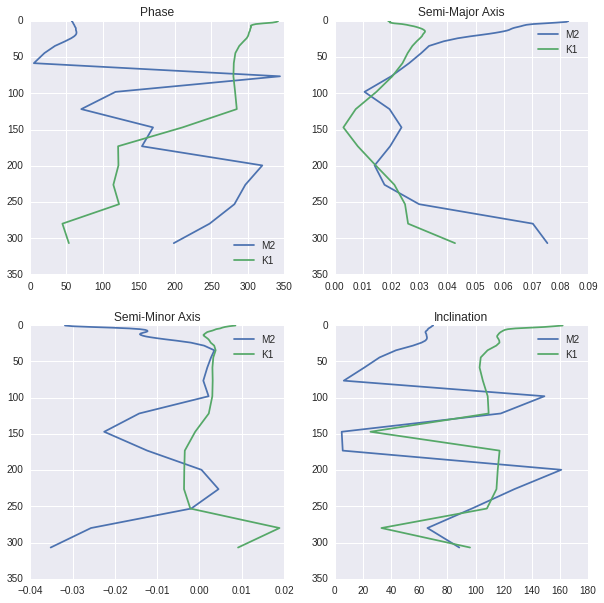

In [30]:
site = 'Central'

fig, axs = plt.subplots(2,2,figsize=(10,10))
for const in ['M2', 'K1']:
    for ax, param in zip(axs.flatten(), baroclinic_tide[site][const]):
        if param=='Phase':
            ax.plot( np.rad2deg(np.unwrap(np.deg2rad(baroclinic_tide[site][const][param]))), depths[site], label =const)  
        else:
            ax.plot( baroclinic_tide[site][const][param], depths[site], label =const)
        ax.set_title(param)
        ax.set_ylim([350,0])
        ax.legend(loc=0)

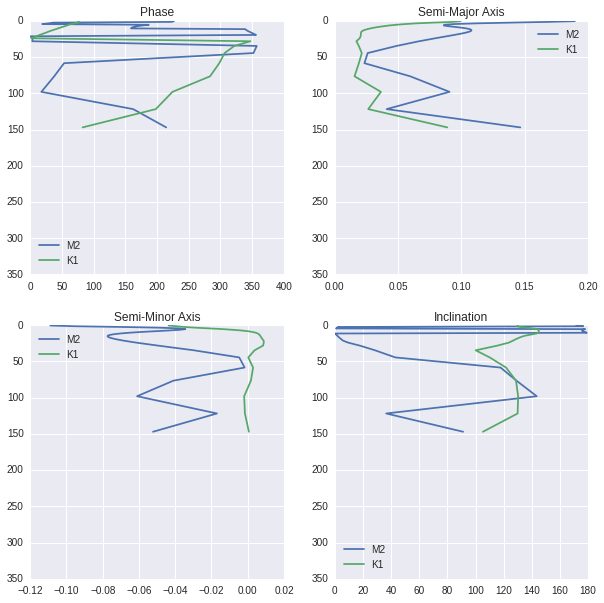

In [31]:
site = 'East'

fig, axs = plt.subplots(2,2,figsize=(10,10))
for const in ['M2', 'K1']:
    for ax, param in zip(axs.flatten(), baroclinic_tide[site][const]):
        if param=='Phase':
            ax.plot( np.rad2deg(np.unwrap(np.deg2rad(baroclinic_tide[site][const][param]))), depths[site], label =const)  
        else:
            ax.plot( baroclinic_tide[site][const][param], depths[site], label =const)
        ax.set_title(param)
        ax.set_ylim([150,0])
        ax.legend(loc=0)

In [32]:
for site in SITES:
    for const in ['M2','K1']:
        print site, const, baroclinic_tide[site][const]['Semi-Major Axis'][0]

East M2 0.189396425346
East K1 0.0994396394724
Central M2 0.0829116295672
Central K1 0.019037466961
ddl M2 0.164538881477
ddl K1 0.0943123135721


I don't think I trust the inlcination and phase

In [33]:
for site in SITES:
    for const in ['M2','K1']:
        print site, const, baroclinic_tide[site][const]['Phase'][0]

East M2 226.584033661
East K1 75.2703783712
Central M2 57.2581651527
Central K1 341.918548993
ddl M2 254.966035753
ddl K1 98.9735655741


Create baroclinic tidal prediction

In [35]:
u_bc={}
v_bc={}
for site in SITES:
    u_bc[site] = np.zeros((len(times[site]), 40))
    v_bc[site] = np.zeros((len(times[site]),40))
    for const in ['M2',]:
        ampU = u_bc_tide[site][const]['amp'] 
        phaU = u_bc_tide[site][const]['phase']
        
        ampV = v_bc_tide[site][const]['amp'] 
        phaV = v_bc_tide[site][const]['phase'] 
        for k in np.arange(u_bc[site].shape[-1]):
            u_bc[site][:,k] = u_bc[site][:,k] + ampU[k]*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaU[k])*np.pi/180)
            v_bc[site][:,k] = v_bc[site][:,k] + ampV[k]*np.cos((NodalCorr[const]['freq']*np.array(times[site]) - phaV[k])*np.pi/180)
        

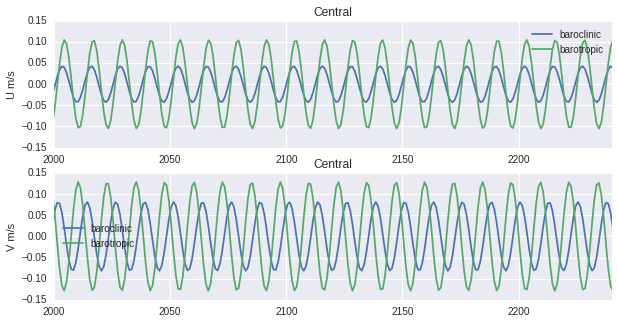

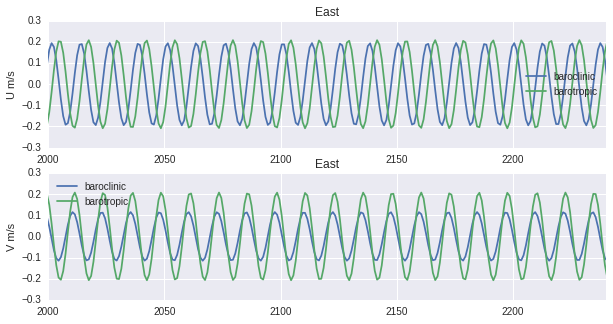

In [36]:
numdays=10
for site in ['Central','East']:
    fig,axs=plt.subplots(2,1,figsize=(10,5))
    ax=axs[0]
    ax.plot(times[site], u_bc[site][:,0],label='baroclinic')
    ax.plot(times[site], u_bt[site][0,:],label='barotropic')
    ax.set_xlim([2000,2000+24*numdays])
    ax.legend(loc=0)
    ax.set_ylabel('U m/s')
    ax.set_title(site)
    ax=axs[1]
    ax.plot(times[site], v_bc[site][:,0],label='baroclinic')
    ax.plot(times[site], v_bt[site][0,:],label='barotropic')
    ax.set_xlim([2000,2000+24*numdays])
    ax.legend(loc=0)
    ax.set_ylabel('V m/s')
    ax.set_title(site)

In [38]:
const = 'M2'
for site in ['Central', 'East']:
    print 'Baroclinic U', u_bc_tide[site][const]['phase'][0]
    print 'Barotropic U', u_tide_baro[site][const]['phase'][0]
    print 'Baroclinic V', v_bc_tide[site][const]['phase'][0]
    print 'Barotropic V', v_tide_baro[site][const]['phase'][0]

 Baroclinic U 117.504262163
Barotropic U [ 143.37971146]
Baroclinic V 63.1615756238
Barotropic V [-45.36903843]
Baroclinic U 55.668243375
Barotropic U [ 152.08264021]
Baroclinic V -43.7787974575
Barotropic V [-21.14352406]


In [ ]:
analyze.depth_average